In [1]:
#imports
import pandas as pd
import numpy as np
from datetime import datetime
from statistics import mode
import matplotlib.pyplot as plt
import pickle
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import time
import warnings
warnings.filterwarnings("ignore")
path = "drive/MyDrive/Booking challenge/"

In [4]:
def drop_timesteps(t, len_trip, proportion=4):
    max_id_to_drop = len(t) // proportion
    n = int(max_id_to_drop * pow(np.random.rand(), 0.3)) + 1 #random number of indexes to drop
    for i in range(n):
        to_skip = int(len_trip * pow(np.random.rand(), 0.3)) #more likely to skip a step towrds the end to add confusion
        t = np.delete(t, to_skip, axis=0)
        len_trip -= 1 #one time step was removed, so the trip is 1 time step smaller
        
    return t, len_trip

In [29]:
from numpy import savez_compressed, load
import random
def getData(filename1, filename3, batch_size=512, skip=0.2, train=True):
    #initiate a batch count for each size of trips
    batch_count = {k: 0 for k in range(50)}
    inputs = {k: [] for k in range(50)}
    targets = {k: [] for k in range(50)}
    while True:
        #load files
        trip_sequences = load(filename1, allow_pickle=True)["arr_0"]
        predictions = load(filename3, allow_pickle=True)["arr_0"]
        
        if train:
          random.seed()
          #Shuffle
          to_shuffle = list(zip(trip_sequences, predictions))
          random.shuffle(to_shuffle)
          trip_sequences, predictions = zip(*to_shuffle)

        predictions = np.array(predictions, dtype="int32")
        
        for i in range(len(trip_sequences)):
          
            #consider trip i
            trip_sequence = trip_sequences[i]
            prediction = predictions[i]
            len_trip = len(trip_sequence)
            
            
            #add info to corresponding  size
            inputs[len_trip].append([trip_sequence])
            targets[len_trip].append(prediction)
            batch_count[len_trip] += 1
            
            if batch_count[len_trip] == batch_size:
                X_trip = np.array([t[0] for t in inputs[len_trip]], dtype='float32')
                y = np.array(targets[len_trip]).reshape(batch_size,)
                #yield the data to feed the 
                yield X_trip, y
                inputs[len_trip] = []
                targets[len_trip] = []
                batch_count[len_trip] = 0
               
               

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, concatenate, Input, TimeDistributed, Layer, Bidirectional, Softmax, Multiply, Lambda, GRU, BatchNormalization, SimpleRNN
from tensorflow.keras.regularizers import L2
from tensorflow.keras import activations
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
import tensorflow as tf

In [15]:
def create_model(l2=0.0001, embedding_size=100, num_cities=39901, dropout=0.5, recurrent_layer=SimpleRNN):
  trips_sequences_input = Input(shape=(None,)) 
  reg=L2(l2=l2)

  #First RNN on cities with Embeddings
  emb_layer = Embedding(output_dim=embedding_size, input_dim=num_cities, input_length=None,
                      mask_zero=False, name="city_embeddings")

  emb_cities = emb_layer(trips_sequences_input) 
  lstm_cities_1 = recurrent_layer(100, dropout=dropout, return_sequences=True,
                    kernel_regularizer=reg)(emb_cities)
  

  lstm_cities_2 = recurrent_layer(100, dropout=dropout, return_sequences=False,
                  kernel_regularizer=reg)(lstm_cities_1)


  
  norm = BatchNormalization()(lstm_cities_2)
  output = Dense(num_cities, activation='softmax')(norm) 
  model = Model(inputs=[trips_sequences_input], outputs=[output])


  
  return model


In [49]:
rnn_model = create_model()
gru_model = create_model(recurrent_layer=GRU)
lstm_model = create_model(recurrent_layer=LSTM)

all_models = [rnn_model, gru_model, lstm_model]

In [50]:
def compile_model(model, learning_rate=0.00003, batch_size=256):

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=.25)
  model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",        
              metrics=['sparse_top_k_categorical_accuracy'])

  

In [51]:
for model in all_models:
  compile_model(model)

In [52]:
num_train_samples = 1257599
num_val_samples = 17913
batch_size = 256
n_epochs=30
training_performance = []
for i, model in enumerate(all_models):
  print(f"\nBeginning Training model {i+1}\n---------------\n")
  train_generator = getData(path+"X_trip_new.npz",
                          path+"y_new.npz", batch_size=batch_size) 


  val_generator = getData(path+"X_val_cities.npz",
                          path+"y_val.npz", batch_size=batch_size, train=False)
  

  history = model.fit(train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=n_epochs,
        validation_data=val_generator,
        validation_steps=num_val_samples // batch_size,
                    batch_size=batch_size)

  training_performance.append(history)
            


Beginning Training model 1
---------------

Epoch 1/30
4912/4912 [==============================] - 182s 37ms/step - loss: 10.0364 - sparse_top_k_categorical_accuracy: 0.0334 - val_loss: 7.9054 - val_sparse_top_k_categorical_accuracy: 0.0742
Epoch 2/30
4912/4912 [==============================] - 182s 37ms/step - loss: 7.6255 - sparse_top_k_categorical_accuracy: 0.0929 - val_loss: 6.9312 - val_sparse_top_k_categorical_accuracy: 0.2278
Epoch 3/30
4912/4912 [==============================] - 182s 37ms/step - loss: 6.7886 - sparse_top_k_categorical_accuracy: 0.1704 - val_loss: 6.3186 - val_sparse_top_k_categorical_accuracy: 0.3036
Epoch 4/30
4912/4912 [==============================] - 182s 37ms/step - loss: 6.2356 - sparse_top_k_categorical_accuracy: 0.2282 - val_loss: 5.9292 - val_sparse_top_k_categorical_accuracy: 0.3526
Epoch 5/30
4912/4912 [==============================] - 183s 37ms/step - loss: 5.8259 - sparse_top_k_categorical_accuracy: 0.2706 - val_loss: 5.6710 - val_sparse_top_

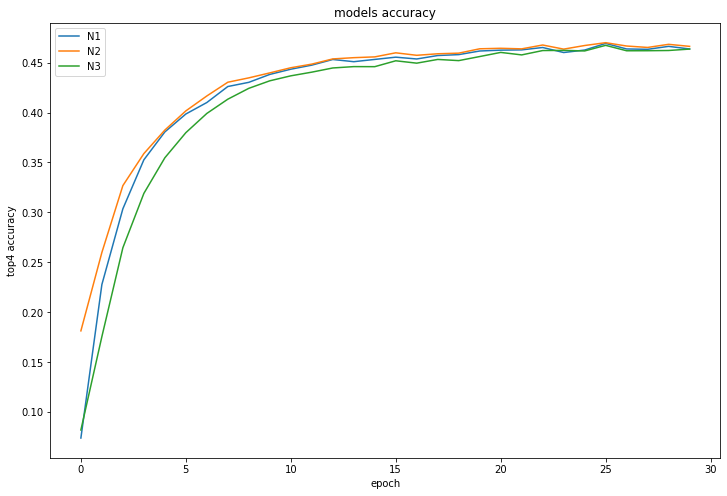

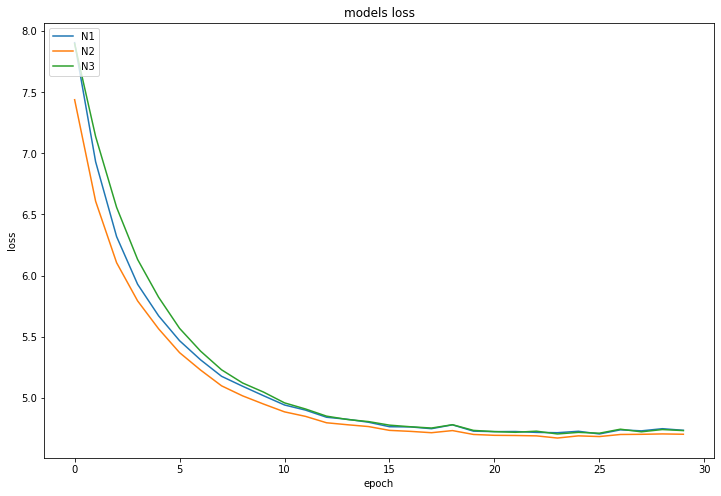

In [55]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(12,8))
for i, history in enumerate(training_performance):
  #plt.plot(history.history['sparse_top_k_categorical_accuracy'])
  plt.plot(history.history['val_sparse_top_k_categorical_accuracy'])
plt.title('models accuracy')
plt.ylabel('top4 accuracy')
plt.xlabel('epoch')
plt.legend(['N1', 'N2', "N3"], loc='upper left')
plt.show()

plt.figure(figsize=(12,8))
for i, history in enumerate(training_performance):
  #plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
plt.title('models loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['N1', 'N2', "N3"], loc='upper left')
plt.show()
